In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [4]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

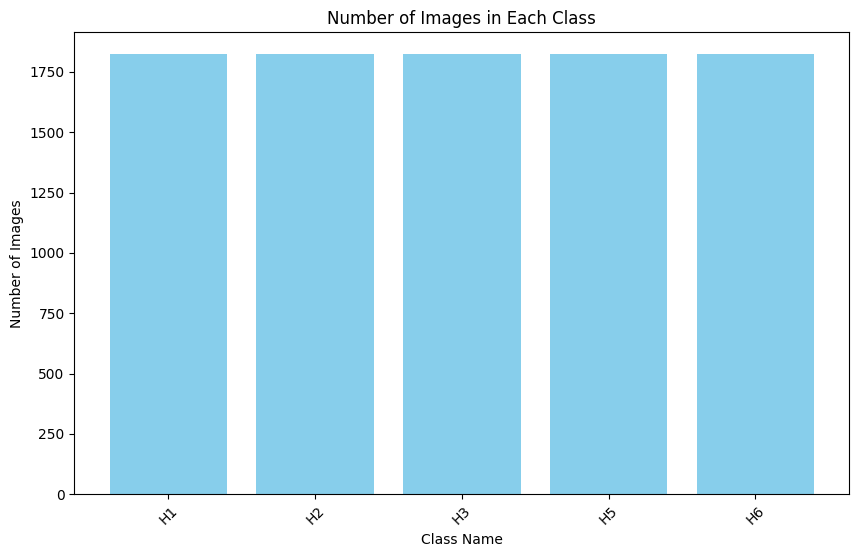

In [5]:
import matplotlib.pyplot as plt

input_folder = "defungi2"

class_names = os.listdir(input_folder)

num_images_per_class = []
for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    num_images = len(os.listdir(class_folder))
    num_images_per_class.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(class_names, num_images_per_class, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = "defungi"
output_folder = "output"

class_names = os.listdir(input_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    output_train_folder = os.path.join(output_folder, "train", class_name)
    output_test_folder = os.path.join(output_folder, "test", class_name)
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    images = os.listdir(class_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    for image in train_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_train_folder, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_test_folder, image)
        shutil.copy(src, dest)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    seed=42
)

class_names = train_dataset.class_names
class_names


Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

In [7]:
image_size = 256

data_generator_with_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        'output/train',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

validation_generator = data_generator_no_aug.flow_from_directory(
        'output/test',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf

# Load VGG16 model without the fully connected layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in vgg_base.layers:
    layer.trainable = False

# Adding custom fully connected layers
x = GlobalAveragePooling2D()(vgg_base.output)
output = Dense(5, activation='softmax')(x)  # Assuming 5 classes for classification

# Create the model
model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=5)

In [10]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/200
228/228 [==============================] - 95s 361ms/step - loss: 1.3418 - accuracy: 0.4963 - val_loss: 1.0133 - val_accuracy: 0.5844
Epoch 2/200
228/228 [==============================] - 78s 342ms/step - loss: 1.0021 - accuracy: 0.5931 - val_loss: 0.8842 - val_accuracy: 0.6414
Epoch 3/200
228/228 [==============================] - 78s 343ms/step - loss: 0.8983 - accuracy: 0.6314 - val_loss: 0.8927 - val_accuracy: 0.6524
Epoch 4/200
228/228 [==============================] - 78s 344ms/step - loss: 0.8696 - accuracy: 0.6390 - val_loss: 0.8020 - val_accuracy: 0.6853
Epoch 5/200
228/228 [==============================] - 78s 342ms/step - loss: 0.8244 - accuracy: 0.6630 - val_loss: 0.7690 - val_accuracy: 0.6908
Epoch 6/200
228/228 [==============================] - 78s 342ms/step - loss: 0.8021 - accuracy: 0.6657 - val_loss: 0.7308 - val_accuracy: 0.7122
Epoch 7/200
228/228 [==============================] - 78s 342ms/step - loss: 0.7543 - accuracy: 0.6860 - val_loss: 0.7619 -

In [11]:
hist = model.history

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
hist = hist.history

ValueError: x and y must have same first dimension, but have shapes (120,) and (19,)

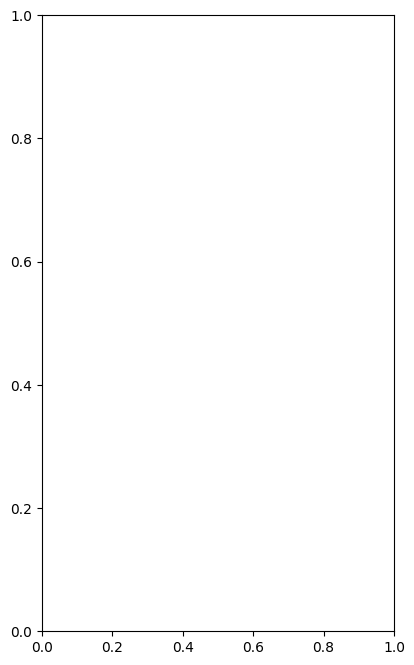

In [13]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

loss=hist['loss']
val_loss=hist['val_loss']

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(120),acc,label='Training Accuracy')
plt.plot(range(120),val_acc,label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(120),loss,label='Training Loss')
plt.plot(range(120),val_loss,label='Validation Loss')
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
model.save("vgg3.h5")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model("vgg3.h5")

test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


57/57 [==============================] - 27s 257ms/step - loss: 0.5091 - accuracy: 0.8448
Test Loss: 0.5091127157211304
Test Accuracy: 0.8448464870452881


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)



1/1 [==============================] - 0s 17ms/step
Image 1 Predicted Class: H6
Image 2 Predicted Class: H2
Image 3 Predicted Class: H3
Image 4 Predicted Class: H5
Image 5 Predicted Class: H3
